In [63]:
from dataclasses import dataclass
from typing import Tuple, Dict, Generator,Callable,Optional
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
os.chdir("..")
from rl.markov_process import MarkovRewardProcess,FiniteMarkovProcess,MarkovProcess
from rl.markov_process import FiniteMarkovRewardProcess
from rl.markov_process import Transition,TransitionStep,ReturnStep
from rl.markov_process import RewardTransition
from rl.distribution import Constant,Categorical,SampledDistribution,Distribution
from rl.gen_utils.common_funcs import get_logistic_func

## List of questions:
<a href='#Q1'>Q1</a> After I get a trace from Class Finite MP, I use plt.hist and my own trace_distribution() to get the distribution. Any suggestions for my implementation? Why isn't there a method in FiniteMarkovProcess()(An @abstractrclass from rl.markov_process.py) to perform the sampling and ploting task? Do you think it's a good idea for me to add such a method to my RL-book.rl repo?
<br><a href='#Q2'>Q2</a> That's my first time to write OOP with python. Are there any design and syntax suggestions to make my code more "modular" as stated in grading criteria in syllabus?
<br><a href='#Q3'>Q3</a> in rl.stock_price.py process1_price_traces() is defined as an independent function rather than a public method of the MRP class. May I know why? To me, this is a useful functionality that should be part of the class. That's also why I define the simulated value function a public method in my implementation. 
<br><a href='#Q3'>Q4</a> For this assignment, I only write a public method to return the value function of one given state. If we want to simulate the value of function of a range of states for an infinite MRP, I personally think a value-table that allows us to store and reuse value of previous state very helpful.
<br>5.


<h1><center>Snakes and Ladders(p1,p2,p4)</center></h1>



<br><a id='Q2'></a>

In [2]:

@dataclass(frozen=True)
class SALState:
    '''Snake and Ladder Game State Object
    '''
    step: int
        
class SAL():
    '''Snake and Ladder Object: np.array of shape(x,2) where for each x x[0]
    is the starting point and x[1] is the end point. x is the current number of 
    all snakes/ladders that have been added by method add()
    '''
    SALArray: np.ndarray
    def __init__(
        self
    ):
        self.SALArray:np.ndarray = np.empty(shape=(0, 2))
            
    def add(
        self,
        newSAL: list
    ):
        '''add another snake/ladder
        '''
        self.SALArray=np.append(self.SALArray,np.array(newSAL).reshape((-1, 2)), axis=0)
    def getSAL(self) -> np.ndarray:
        '''return all snake/ladders that have been added
        '''
        return self.SALArray
    
    
class SALMPFinite(FiniteMarkovProcess[SALState]):
    '''Model the game in FMP
    '''
    def __init__(
        self,
        snakePos: np.ndarray,
        ladderPos: np.ndarray
    ):
        self.snakePos: np.ndarray = snakePos
        self.ladderPos: np.ndarray = ladderPos
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Transition[SALState]:
        '''
        Transition map of FMP
        '''
        d: Dict[InventoryState, Categorical[InventoryState]] = {}
        for currentStep in range(100):
            state_probs_map: Mapping[SALState, float] = {}
            for dice in range(1,7):
                finalStep,probMultiplier = self.get_final_state(currentStep+dice)
                state_probs_map[SALState(int(finalStep))]=probMultiplier*1/6
                #probMutiplier is used to capture the corner cases near destination
                d[SALState(currentStep)] = Categorical(state_probs_map)
        d[SALState(100)]=None
        return d
    
    def get_final_state(self,nxtStep: int) -> Tuple[int,int]:
        """Use Recursion to get final location wrt nxtStep"""
        # arrive or go beyond destination
        if nxtStep>99:
            probMultiplier=nxtStep-99
            step=100
        else:
            probMultiplier=1
            step=nxtStep
        # snake and ladder cases
        for snake in self.snakePos:
            if snake[0]==nxtStep:
                step,probMultiplier=self.get_final_state(snake[1])
                break
                
        for ladder in self.ladderPos:
            if ladder[0]==nxtStep:
                step,probMultiplier=self.get_final_state(ladder[1])
                break
        return step,probMultiplier

In [3]:
snake=SAL()
ladder=SAL()

snake.add([16,6])
snake.add([47,26])
snake.add([49,11])
snake.add([56,53])
snake.add([62,19])
snake.add([64,60])
snake.add([87,24])
snake.add([93,73])
snake.add([95,75])
snake.add([98,78])

ladder.add([1,38])
ladder.add([4,14])
ladder.add([9,31])
ladder.add([21,42])
ladder.add([28,84])
ladder.add([36,44])
ladder.add([51,67])
ladder.add([71,91])
ladder.add([80,100])

newGame = SALMPFinite(
        snakePos=snake.getSAL(),
        ladderPos=ladder.getSAL()       
)


print("Transition Map")
print("--------------")
print(FiniteMarkovProcess(newGame.transition_map))


Transition Map
--------------
From State SALState(step=0):
  To State SALState(step=38) with Probability 0.167
  To State SALState(step=2) with Probability 0.167
  To State SALState(step=3) with Probability 0.167
  To State SALState(step=14) with Probability 0.167
  To State SALState(step=5) with Probability 0.167
  To State SALState(step=6) with Probability 0.167
From State SALState(step=1):
  To State SALState(step=2) with Probability 0.167
  To State SALState(step=3) with Probability 0.167
  To State SALState(step=14) with Probability 0.167
  To State SALState(step=5) with Probability 0.167
  To State SALState(step=6) with Probability 0.167
  To State SALState(step=7) with Probability 0.167
From State SALState(step=2):
  To State SALState(step=3) with Probability 0.167
  To State SALState(step=14) with Probability 0.167
  To State SALState(step=5) with Probability 0.167
  To State SALState(step=6) with Probability 0.167
  To State SALState(step=7) with Probability 0.167
  To State S

In [4]:
def trace_distribution(trace:Generator[SALState, None, None],nSample:int) -> np.ndarray:
    result=[]
    for _ in range(nSample):
        i=next(trace)
        counter=0
        while True:
            try:
                next(i)
                counter=counter+1
            except StopIteration:
                break
        result.append(counter)
    return np.array(result)


<a id='Q1'></a>

mean: 36.3868 std: 23.07014923575485


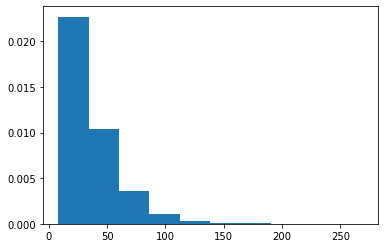

In [131]:
trace=newGame.traces(start_state_distribution=Constant(SALState(0)))
samples=trace_distribution(trace=trace,nSample=10000)
print("mean:",samples.mean(),"std:",samples.std())
plt.hist(samples,density=True)
plt.show()

In [6]:
class SALMRPFinite(FiniteMarkovRewardProcess[SALState]):

    def __init__(
        self,
        snakePos: np.ndarray,
        ladderPos: np.ndarray
    ):
        self.snakePos: np.ndarray = snakePos
        self.ladderPos: np.ndarray = ladderPos
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> RewardTransition[SALState]:
        d: Dict[SALState, Categorical[Tuple[SALState, float]]] = {}
        for currentStep in range(100):
            sr_probs_map: Dict[Tuple[SALState, float], float] ={}
            for dice in range(1,7):
                #probMutiplier is used to capture the corner cases near destination
                finalStep,probMultiplier = self.get_final_state(currentStep+dice)
                reward=1
                sr_probs_map[(SALState(int(finalStep)), reward)] = probMultiplier*1/6
                d[SALState(currentStep)] = Categorical(sr_probs_map)
        d[SALState(100)]=None
        return d
    
    def get_final_state(self,nxtStep: int) -> Tuple[int,int]:
        """Use Recursion to get final location wrt nxtStep
        """
        # arrive or go beyond destination
        if nxtStep>99:
            probMultiplier=nxtStep-99
            step=100
        else:
            probMultiplier=1
            step=nxtStep
        # snake and ladder cases
        for snake in self.snakePos:
            if snake[0]==nxtStep:
                step,probMultiplier=self.get_final_state(snake[1])
                break
                
        for ladder in self.ladderPos:
            if ladder[0]==nxtStep:
                step,probMultiplier=self.get_final_state(ladder[1])
                break
        return step,probMultiplier


In [7]:
# Expected number of time steps:{SALState(step=0): 35.692}
reward_game=SALMRPFinite(        
    snakePos=snake.getSAL(),
    ladderPos=ladder.getSAL() 
)
reward_game.display_value_function(1)

{SALState(step=0): 35.692,
 SALState(step=5): 35.758,
 SALState(step=6): 35.548,
 SALState(step=47): 26.843,
 SALState(step=1): 36.335,
 SALState(step=2): 36.154,
 SALState(step=4): 35.932,
 SALState(step=3): 35.664,
 SALState(step=12): 34.285,
 SALState(step=13): 33.906,
 SALState(step=14): 33.574,
 SALState(step=15): 33.07,
 SALState(step=16): 32.132,
 SALState(step=17): 31.887,
 SALState(step=18): 31.728,
 SALState(step=19): 31.631,
 SALState(step=20): 31.579,
 SALState(step=21): 31.807,
 SALState(step=22): 29.921,
 SALState(step=23): 30.418,
 SALState(step=24): 30.772,
 SALState(step=25): 31.052,
 SALState(step=26): 31.265,
 SALState(step=27): 31.416,
 SALState(step=28): 33.659,
 SALState(step=29): 33.402,
 SALState(step=30): 32.897,
 SALState(step=31): 32.728,
 SALState(step=32): 32.546,
 SALState(step=34): 32.062,
 SALState(step=33): 32.321,
 SALState(step=35): 31.856,
 SALState(step=36): 31.885,
 SALState(step=37): 31.718,
 SALState(step=7): 35.313,
 SALState(step=8): 35.065,
 S

35.69 is very close to 36.38 we derived previously

<h1><center>Snakes and Ladders(p1,p2,p4)</center></h1>



In [8]:
@dataclass(frozen=True)
class LilypadState:
    '''Frog Puzzle State Object
    '''
    step: int

class FrogPuzzleFinite(FiniteMarkovRewardProcess[LilypadState]):
    '''Frog Puzzle Game with nState+2 states in total: nState Lotus and 0,nState+1 represent two banks of river.
    As we set reward=1, value function of state 0 is the expected number of hops.
    '''
    def __init__(
        self,
        nState: int
    ):
        self.nState: int = nState
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> RewardTransition[LilypadState]:
        d: Dict[LilypadState, Categorical[Tuple[LilypadState, float]]] = {}
        for currentStep in range(self.nState+1):
            sr_probs_map: Dict[Tuple[LilypadState, float], float] ={}
            for nxtStep in range(currentStep+1,self.nState+2):
                reward=1
                sr_probs_map[(LilypadState(nxtStep), reward)] = 1/(self.nState-currentStep+1)
                d[LilypadState(currentStep)] = Categorical(sr_probs_map)
        d[LilypadState(self.nState+1)]=None
        return d
 

In [9]:
new_puzzle=FrogPuzzleFinite(10)
print("Transition Map")
print("--------------")
print(FiniteMarkovProcess(new_puzzle.transition_map))
new_puzzle.display_value_function(1)

Transition Map
--------------
From State LilypadState(step=0):
  To State LilypadState(step=1) with Probability 0.091
  To State LilypadState(step=2) with Probability 0.091
  To State LilypadState(step=3) with Probability 0.091
  To State LilypadState(step=4) with Probability 0.091
  To State LilypadState(step=5) with Probability 0.091
  To State LilypadState(step=6) with Probability 0.091
  To State LilypadState(step=7) with Probability 0.091
  To State LilypadState(step=8) with Probability 0.091
  To State LilypadState(step=9) with Probability 0.091
  To State LilypadState(step=10) with Probability 0.091
  To State LilypadState(step=11) with Probability 0.091
From State LilypadState(step=1):
  To State LilypadState(step=2) with Probability 0.100
  To State LilypadState(step=3) with Probability 0.100
  To State LilypadState(step=4) with Probability 0.100
  To State LilypadState(step=5) with Probability 0.100
  To State LilypadState(step=6) with Probability 0.100
  To State LilypadStat

<h1><center>Stock Price (p5)</center></h1>


<a id='Q3'></a>

In [122]:
@dataclass(frozen=True)
class StateMP1:
    price: int

class StockPriceMP1(MarkovRewardProcess[StateMP1]):
    ''' A class that implements the interface of the @abstractclass MarkovRewardProcess and allow flexibility in
        specifying my own function f. This is an infinite-states, non-terminating MRP. Compute it’s
        Value Function for any discount factor 0 ≤ γ < 1.
    '''
    level_param: int  # level to which price mean-reverts
    alpha1: float  # strength of mean-reversion (non-negative value)
    f: Callable[[int], float]# reward is function f of stock price

    def __init__(
        self,
        level_param: int,
        alpha1: float,
        f: Callable[[int], float]
    ):
        self.level_param: int= level_param
        self.alpha1: float = alpha1
        self.f: Callable[[int], float]= f
    
    def up_prob(self, state: StateMP1) -> float:
        return get_logistic_func(self.alpha1)(self.level_param - state.price)

    def transition_reward(self, state: StateMP1) -> Optional[Distribution[Tuple[StateMP1, float]]]:
        '''Given a state, returns a distribution of the next state
        and reward from transitioning between the states.
        '''
        up_p = self.up_prob(state)
        reward_up=self.f(state.price + 1)
        reward_down=self.f(state.price - 1)
        return Categorical({
            (StateMP1(state.price + 1),reward_up): up_p,
            (StateMP1(state.price - 1),reward_down): 1 - up_p
        })
    def get_simulated_value_function(self,gamma: float ,start_price: int,
                                        time_steps: int,
                                        num_traces: int) -> float:
        """
            Compute the value function for a given state based on the expected sum of discounted rewards. 
            The expected value is derived by time_steps each sample and numtraces samples each simulation.
        """
        start_state_distribution = Constant(StateMP1(start_price))
        trace_iter=self.reward_traces(start_state_distribution)
        value_list=[]
        for _ in range(num_traces):
            nxt_trace=next(trace_iter)
            current_return_=0
            for _ in range(time_steps):
                current_return_=next(nxt_trace).add_return(gamma,current_return_).return_
            value_list.append(current_return_)
        print("All values we get from simulations: ",value_list)
        return np.mean(np.array(value_list))


Let's test our MRP with a constant reward function

In [123]:
NewStockProcess=StockPriceMP1(level_param=15,alpha1=0.3,f=lambda X: X)

In [126]:
value_X=NewStockProcess.get_simulated_value_function(gamma=0.9,start_price=12,time_steps=10000,num_traces=5)

All values we get from simulations:  [132.98327819968807, 146.32649083154982, 144.09767273117882, 126.43362598736766, 138.68831726520173]


In [129]:
print("expected value function at StateMP1(12) with 5 simulations: ",value_X)

expected value function at StateMP1(12) with 5 simulations:  137.70587700299723
